In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = mls
band = 2
commitnumber = 5014a19
conc = None
dv = 0.01
klin = 0
molecule = h2o
ng_adju = [-2, -2, 0]
ng_refs = [2, 3, 6]
nv = 100
option_compute_btable = 0
option_compute_ktable = 1
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (10, 250), (500, 250)]
tsfc = 294
vmax = 540
vmin = 340
w_diffuse = [(1.66, 1.66), (1.8, 1.8, 1.8), (1.8, 1.66, 1.45, 1.45, 1.45, 1.45)]
wgt = [(0.6, 0.6), (0.6, 0.6, 0.6), (0.6, 0.6, 0.6, 0.6, 0.6, 0.6)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

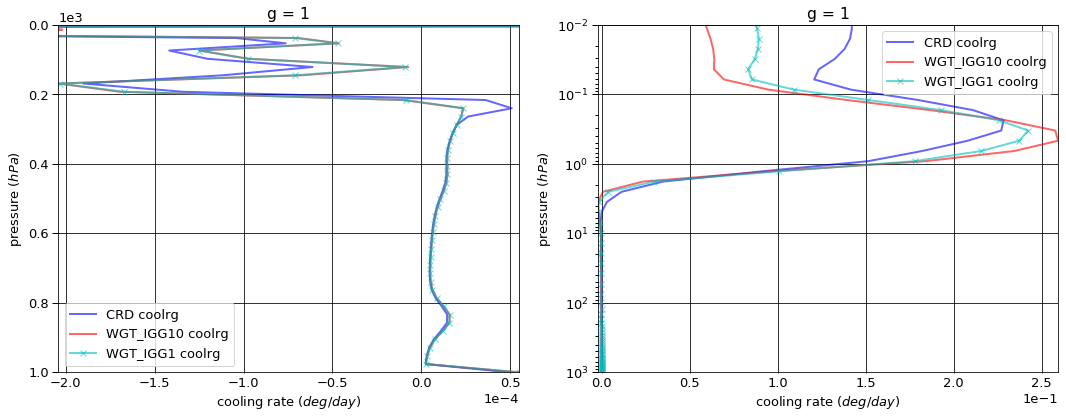

# Figure: cooling rate g-group 2

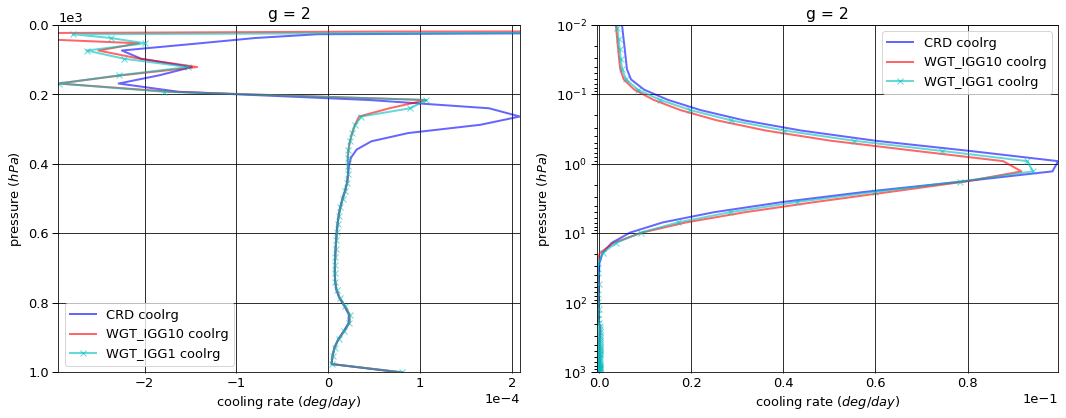

# Figure: cooling rate g-group 3

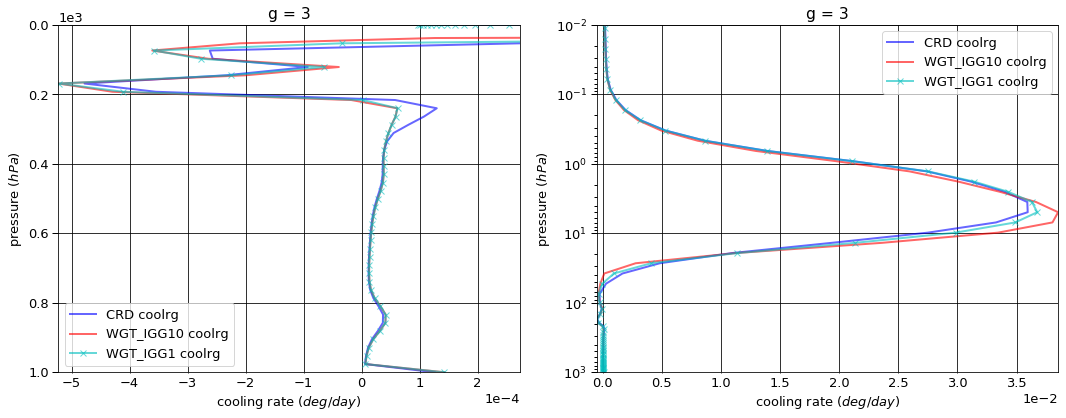

# Figure: cooling rate g-group 4

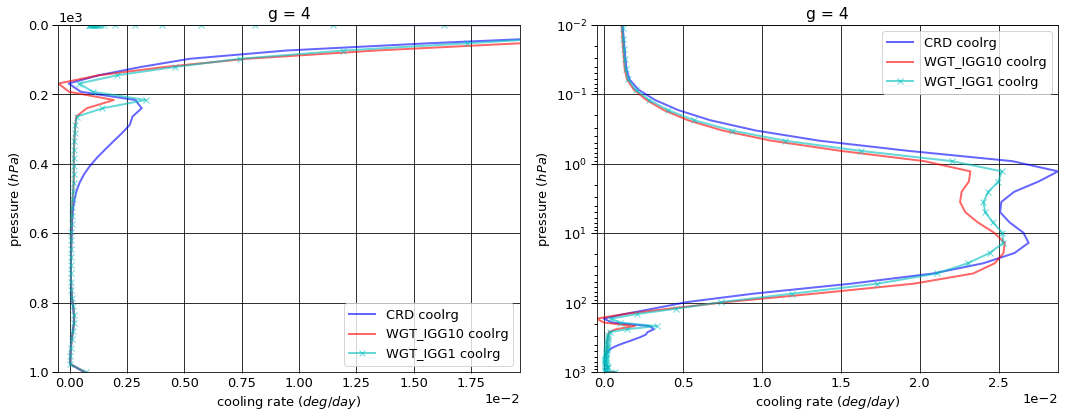

# Figure: cooling rate g-group 5

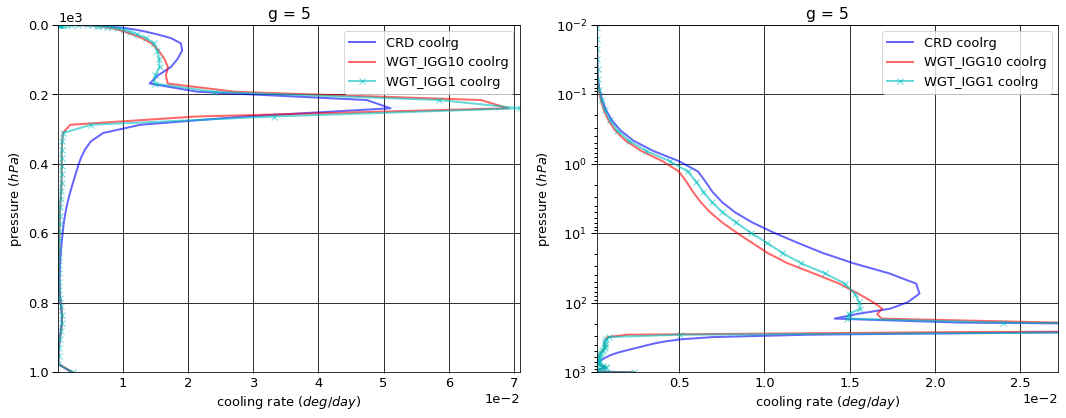

# Figure: cooling rate g-group 6

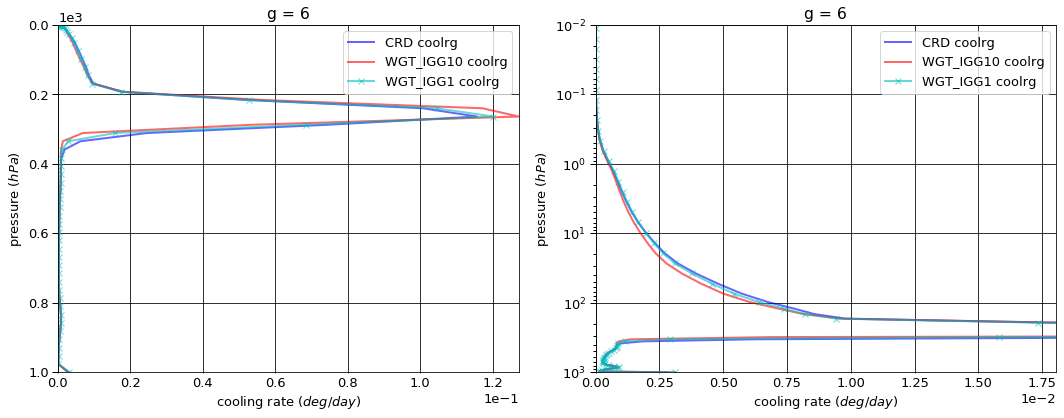

# Figure: cooling rate g-group 7

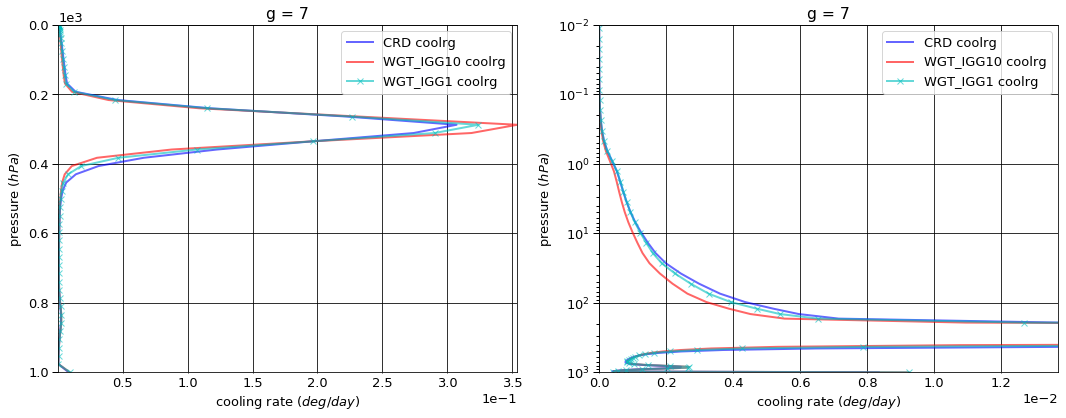

# Figure: cooling rate g-group 8

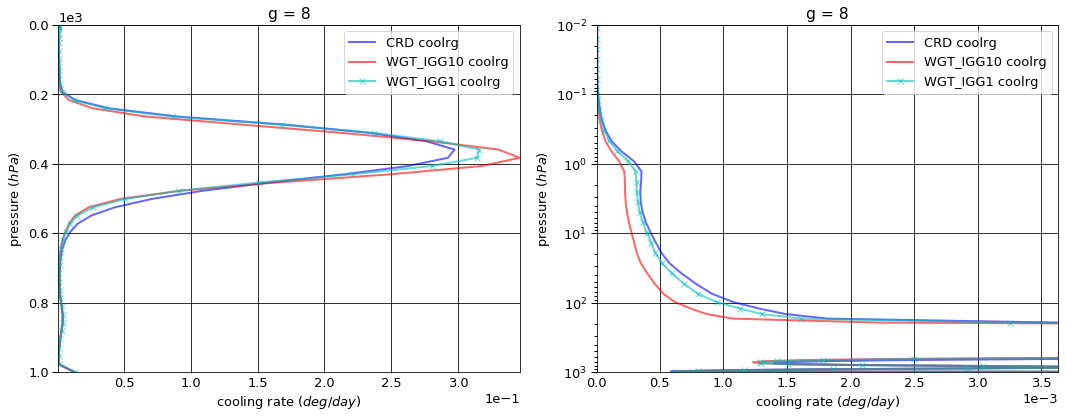

# Figure: cooling rate g-group 9

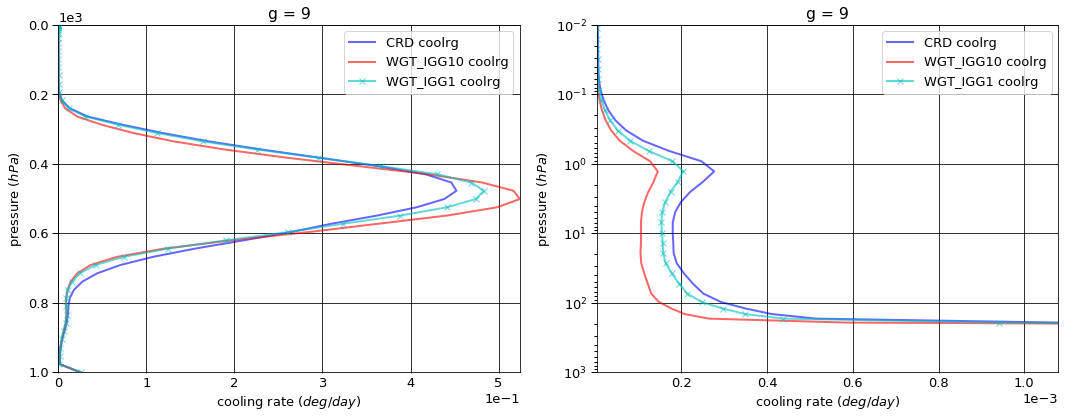

# Figure: cooling rate g-group 10

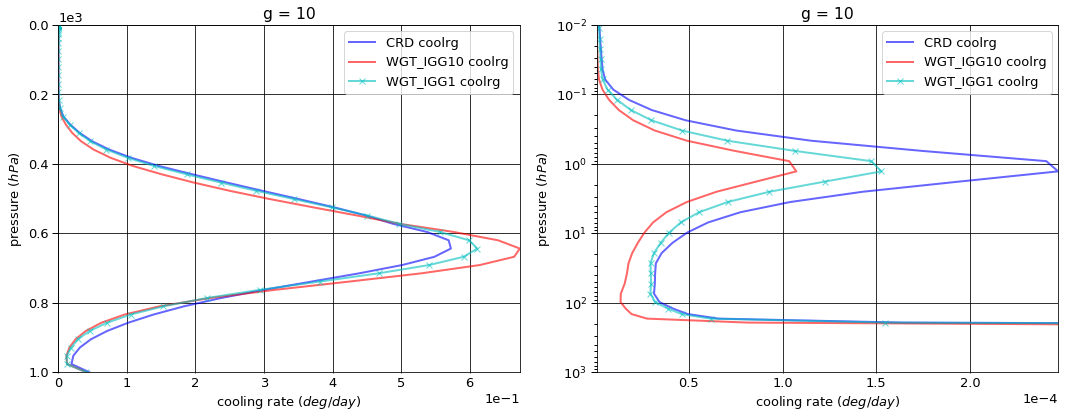

# Figure: cooling rate g-group 11

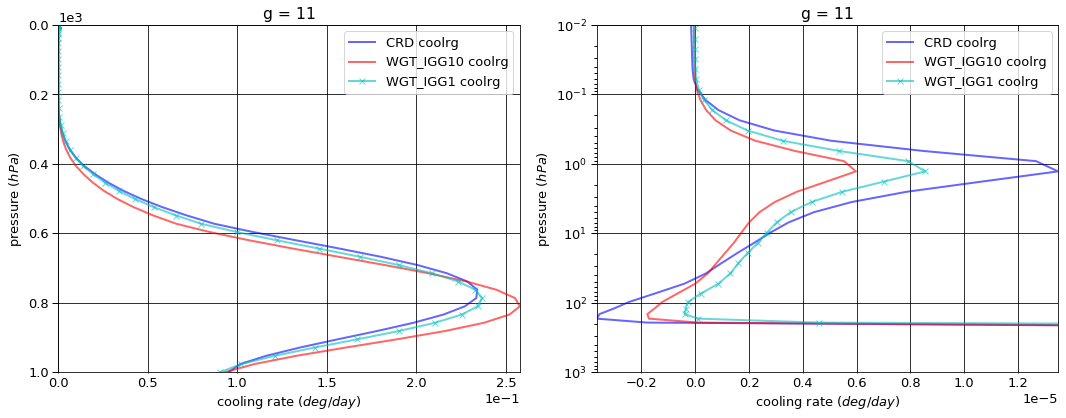

# Figure: cooling rate g-group total

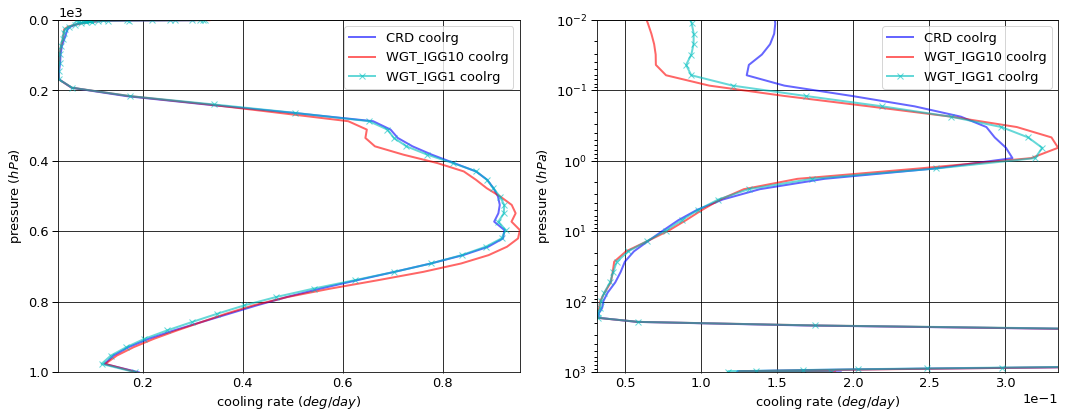

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.029595   0.000000  -0.029595
   1013.0   76     -0.042674   0.042538  -0.000136
2  0.0      1      -0.043160   0.000000  -0.043160
   1013.0   76     -0.063910   0.063697  -0.000212
3  0.0      1      -0.066629   0.000000  -0.066629
   1013.0   76     -0.110859   0.110512  -0.000348
4  0.0      1      -0.281272   0.000000  -0.281272
   1013.0   76     -0.551445   0.549665  -0.001780
5  0.0      1      -0.933302   0.000000  -0.933302
   1013.0   76     -1.844500   1.838563  -0.005937
6  0.0      1      -1.292949   0.000000  -1.292949
   1013.0   76     -2.423618   2.415902  -0.007715
7  0.0      1      -4.215189   0.000000  -4.215189
   1013.0   76     -7.217686   7.194662  -0.023024
8  0.0      1      -6.745770   0.000000  -6.745770
   1013.0   76    -10.504357  10.469982  -0.034375
9  0.0      1     -14.508102   0.000000 -14.508102
   1013.0   76    -20.211956  20.143295  -0.068660
10 0.0      1     -21.562632   0.000000 -21.562632
   1013.0   76    -27.097131  26.950922  -0.146209
11 0.0      1     -10.690336   0.000000 -10.690336
   1013.0   76    -12.247661  11.421745  -0.825916


WGT_IGG10


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.029964   0.000000  -0.029964
   1013.0   76     -0.043973   0.043822  -0.000151
2  0.0      1      -0.043957   0.000000  -0.043957
   1013.0   76     -0.064766   0.064544  -0.000222
3  0.0      1      -0.066792   0.000000  -0.066792
   1013.0   76     -0.115005   0.114611  -0.000394
4  0.0      1      -0.263089   0.000000  -0.263089
   1013.0   76     -0.565678   0.563740  -0.001938
5  0.0      1      -0.882230   0.000000  -0.882230
   1013.0   76     -1.896140   1.889644  -0.006496
6  0.0      1      -1.252956   0.000000  -1.252956
   1013.0   76     -2.500204   2.491639  -0.008565
7  0.0      1      -4.137125   0.000000  -4.137125
   1013.0   76     -7.439875   7.414387  -0.025488
8  0.0      1      -6.750662   0.000000  -6.750662
   1013.0   76    -10.714481  10.677775  -0.036706
9  0.0      1     -14.611966   0.000000 -14.611966
   1013.0   76    -20.417449  20.347468  -0.069981
10 0.0      1     -21.635899   0.000000 -21.635899
   1013.0   76    -26.860736  26.737705  -0.123032
11 0.0      1     -10.455128   0.000000 -10.455128
   1013.0   76    -11.697488  11.167553  -0.529935


WGT_IGG1


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.029878   0.000000  -0.029878
   1013.0   76     -0.043973   0.043822  -0.000151
2  0.0      1      -0.043656   0.000000  -0.043656
   1013.0   76     -0.064766   0.064544  -0.000222
3  0.0      1      -0.066245   0.000000  -0.066245
   1013.0   76     -0.115005   0.114611  -0.000394
4  0.0      1      -0.263721   0.000000  -0.263721
   1013.0   76     -0.565678   0.563740  -0.001938
5  0.0      1      -0.890517   0.000000  -0.890517
   1013.0   76     -1.896140   1.889644  -0.006496
6  0.0      1      -1.260989   0.000000  -1.260989
   1013.0   76     -2.500204   2.491639  -0.008565
7  0.0      1      -4.143156   0.000000  -4.143156
   1013.0   76     -7.439875   7.414387  -0.025488
8  0.0      1      -6.693852   0.000000  -6.693852
   1013.0   76    -10.714481  10.677775  -0.036706
9  0.0      1     -14.474862   0.000000 -14.474862
   1013.0   76    -20.417449  20.347395  -0.070054
10 0.0      1     -21.433244   0.000000 -21.433244
   1013.0   76    -26.860736  26.736121  -0.124615
11 0.0      1     -10.361814   0.000000 -10.361814
   1013.0   76    -11.697488  11.113022  -0.584467


WGT_IGG10 - CRD


flug      fldg     fnetg
g  pressure level                              
1  0.0      1     -0.000369  0.000000 -0.000369
   1013.0   76    -0.001299  0.001285 -0.000014
2  0.0      1     -0.000797  0.000000 -0.000797
   1013.0   76    -0.000857  0.000847 -0.000009
3  0.0      1     -0.000163  0.000000 -0.000163
   1013.0   76    -0.004146  0.004100 -0.000046
4  0.0      1      0.018183  0.000000  0.018183
   1013.0   76    -0.014233  0.014075 -0.000158
5  0.0      1      0.051072  0.000000  0.051072
   1013.0   76    -0.051641  0.051082 -0.000559
6  0.0      1      0.039993  0.000000  0.039993
   1013.0   76    -0.076586  0.075737 -0.000850
7  0.0      1      0.078064  0.000000  0.078064
   1013.0   76    -0.222189  0.219725 -0.002464
8  0.0      1     -0.004892  0.000000 -0.004892
   1013.0   76    -0.210124  0.207793 -0.002332
9  0.0      1     -0.103864  0.000000 -0.103864
   1013.0   76    -0.205493  0.204173 -0.001321
10 0.0      1     -0.073267  0.000000 -0.073267
   1013.0   76     0.236395 -0.213217  0.023177
11 0.0      1      0.235208  0.000000  0.235208
   1013.0   76     0.550173 -0.254192  0.295981


WGT_IGG1 - CRD


flug      fldg     fnetg
g  pressure level                              
1  0.0      1     -0.000283  0.000000 -0.000283
   1013.0   76    -0.001299  0.001285 -0.000014
2  0.0      1     -0.000496  0.000000 -0.000496
   1013.0   76    -0.000857  0.000847 -0.000009
3  0.0      1      0.000383  0.000000  0.000383
   1013.0   76    -0.004146  0.004100 -0.000046
4  0.0      1      0.017552  0.000000  0.017552
   1013.0   76    -0.014233  0.014075 -0.000158
5  0.0      1      0.042785  0.000000  0.042785
   1013.0   76    -0.051641  0.051082 -0.000559
6  0.0      1      0.031960  0.000000  0.031960
   1013.0   76    -0.076586  0.075737 -0.000850
7  0.0      1      0.072033  0.000000  0.072033
   1013.0   76    -0.222189  0.219725 -0.002464
8  0.0      1      0.051918  0.000000  0.051918
   1013.0   76    -0.210124  0.207793 -0.002332
9  0.0      1      0.033240  0.000000  0.033240
   1013.0   76    -0.205493  0.204100 -0.001393
10 0.0      1      0.129388  0.000000  0.129388
   1013.0   76     0.236395 -0.214801  0.021593
11 0.0      1      0.328522  0.000000  0.328522
   1013.0   76     0.550173 -0.308723  0.241449

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1      1.167134e-01
   1001.112500 75     4.941000e-05
2  0.000312    1      2.990380e-03
   1001.112500 75     7.703503e-05
3  0.000312    1      1.236744e-04
   1001.112500 75     1.262538e-04
4  0.000312    1      8.311010e-04
   1001.112500 75     6.456585e-04
5  0.000312    1      1.168948e-04
   1001.112500 75     2.151764e-03
6  0.000312    1      1.140093e-06
   1001.112500 75     2.799043e-03
7  0.000312    1      2.114431e-06
   1001.112500 75     8.352565e-03
8  0.000312    1      6.312625e-06
   1001.112500 75     1.246790e-02
9  0.000312    1      2.752388e-06
   1001.112500 75     2.483217e-02
10 0.000312    1     -6.580947e-07
   1001.112500 75     4.545276e-02
11 0.000312    1     -2.351917e-07
   1001.112500 75     9.497691e-02


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1      3.713808e-02
   1001.112500 75     5.462058e-05
2  0.000312    1      2.152346e-03
   1001.112500 75     8.044860e-05
3  0.000312    1      1.008338e-04
   1001.112500 75     1.428524e-04
4  0.000312    1      8.354940e-04
   1001.112500 75     7.026508e-04
5  0.000312    1      1.191950e-04
   1001.112500 75     2.355272e-03
6  0.000312    1      9.465185e-07
   1001.112500 75     3.105603e-03
7  0.000312    1      1.489899e-06
   1001.112500 75     9.241366e-03
8  0.000312    1      2.164709e-06
   1001.112500 75     1.330888e-02
9  0.000312    1      8.931663e-07
   1001.112500 75     2.538062e-02
10 0.000312    1     -5.011722e-07
   1001.112500 75     4.092233e-02
11 0.000312    1     -8.938868e-08
   1001.112500 75     9.290603e-02


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1      6.370586e-02
   1001.112500 75     5.462058e-05
2  0.000312    1      2.172434e-03
   1001.112500 75     8.044860e-05
3  0.000312    1      9.705035e-05
   1001.112500 75     1.428524e-04
4  0.000312    1      8.629519e-04
   1001.112500 75     7.026508e-04
5  0.000312    1      1.319944e-04
   1001.112500 75     2.355272e-03
6  0.000312    1      1.080653e-06
   1001.112500 75     3.105603e-03
7  0.000312    1      1.901022e-06
   1001.112500 75     9.241366e-03
8  0.000312    1      3.450422e-06
   1001.112500 75     1.330888e-02
9  0.000312    1      1.791112e-06
   1001.112500 75     2.541006e-02
10 0.000312    1      3.067843e-07
   1001.112500 75     4.082950e-02
11 0.000312    1     -8.393698e-08
   1001.112500 75     9.022320e-02


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -7.957536e-02
   1001.112500 75     5.210573e-06
2  0.000312    1     -8.380340e-04
   1001.112500 75     3.413572e-06
3  0.000312    1     -2.284057e-05
   1001.112500 75     1.659865e-05
4  0.000312    1      4.393000e-06
   1001.112500 75     5.699225e-05
5  0.000312    1      2.300170e-06
   1001.112500 75     2.035075e-04
6  0.000312    1     -1.935744e-07
   1001.112500 75     3.065609e-04
7  0.000312    1     -6.245320e-07
   1001.112500 75     8.888006e-04
8  0.000312    1     -4.147916e-06
   1001.112500 75     8.409820e-04
9  0.000312    1     -1.859222e-06
   1001.112500 75     5.484480e-04
10 0.000312    1      1.569225e-07
   1001.112500 75    -4.530430e-03
11 0.000312    1      1.458030e-07
   1001.112500 75    -2.070889e-03


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -5.300758e-02
   1001.112500 75     5.210573e-06
2  0.000312    1     -8.179460e-04
   1001.112500 75     3.413572e-06
3  0.000312    1     -2.662404e-05
   1001.112500 75     1.659865e-05
4  0.000312    1      3.185085e-05
   1001.112500 75     5.699225e-05
5  0.000312    1      1.509952e-05
   1001.112500 75     2.035075e-04
6  0.000312    1     -5.944030e-08
   1001.112500 75     3.065609e-04
7  0.000312    1     -2.134089e-07
   1001.112500 75     8.888006e-04
8  0.000312    1     -2.862203e-06
   1001.112500 75     8.409820e-04
9  0.000312    1     -9.612765e-07
   1001.112500 75     5.778920e-04
10 0.000312    1      9.648790e-07
   1001.112500 75    -4.623260e-03
11 0.000312    1      1.512547e-07
   1001.112500 75    -4.753719e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-60.368935,0.000000,-60.368935
1013.0,76,-82.315796,81.201482,-1.114312



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-60.129767,0.000000,-60.129767
1013.0,76,-82.315795,81.512889,-0.802907



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-59.661935,0.000000,-59.661935
1013.0,76,-82.315795,81.456701,-0.859095



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,2.391679e-01,0.000000,0.239168
1013.0,76,5.470000e-07,0.311407,0.311405



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,7.070003e-01,0.000000,0.707000
1013.0,76,5.470000e-07,0.255219,0.255217


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.120787
1001.112500,75,0.191931



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.040351
1001.112500,75,0.188201



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.066979
1001.112500,75,0.185454



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.080436
1001.112500,75,-0.003731



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.053808
1001.112500,75,-0.006477


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.00055,0.000534
2,0.00080,0.000787
3,0.00145,0.001397
4,0.00705,0.006872
5,0.02370,0.023035
6,0.03135,0.030373
7,0.09330,0.090382
8,0.13290,0.130163
9,0.24960,0.248038


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.383983e-18
2,2.078360e-19
3,1.627159e-19
4,1.444222e-20
5,1.281852e-21
6,1.233578e-20
7,2.471060e-21
8,4.949937e-22
9,9.915535e-23


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.383983e-18,NaN,0.00055,0.000534,0.00055,0.000534,1.0
2,2.078360e-19,0.087180,0.00080,0.000787,0.00135,0.001321,1.0
3,1.627159e-19,0.782905,0.00145,0.001397,0.00280,0.002718,10.0
4,1.444222e-20,0.088757,0.00705,0.006872,0.00985,0.009590,10.0
5,1.281852e-21,0.088757,0.02370,0.023035,0.03355,0.032625,10.0
6,1.233578e-20,9.623408,0.03135,0.030373,0.06490,0.062998,500.0
7,2.471060e-21,0.200316,0.09330,0.090382,0.15820,0.153381,500.0
8,4.949937e-22,0.200316,0.13290,0.130163,0.29110,0.283544,500.0
9,9.915535e-23,0.200316,0.24960,0.248038,0.54070,0.531582,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
